# Project 00: Food Vision Big

In this notebook, we're going to build a Transfer Learning Model using data from the Food101 dataset.

We've got a goal of beating [DeepFood](https://www.researchgate.net/publication/304163308_DeepFood_Deep_Learning-Based_Food_Image_Recognition_for_Computer-Aided_Dietary_Assessment), a 2016 paper which uses Convolutional Neural Network trained for 2-3 days, to acheive **77.4%** top-1 accuracy

> 🔑 **Note:** **Top-1 accuracy** means "accuracy for the top softmax activation value output by the model"

|                 | Food Vision Big         |
|-----------------|-------------------------|
| Dataset Source  | TensorFlow datasets     |
| Train Data      | 75,750 images           |
| Mixed Precision | yes                     |
| Data Loading    | Perfomant `tf.data` API |
| Target Results  | 77.4% top-1 accuracy    |

## Check GPU

We're going to be using mixed precision training.

> For Mixed Precision training to work, you need to access a GPU with compute capability of 7.0+.

In [1]:
# Check GPU
!nvidia-smi -L

GPU 0: NVIDIA GeForce RTX 3060 Ti (UUID: GPU-4db4d962-71a3-5709-c39b-2fda5802e9d6)


In [2]:
# Check tensorflow version and allocate maximum possible memory from GPU
import tensorflow as tf
print(tf.__version__)

gpus = tf.config.list_physical_devices('GPU')
if gpus:
  # Restrict TensorFlow to only allocate 1GB of memory on the first GPU
  try:
    tf.config.set_logical_device_configuration(
        gpus[0],
        [tf.config.LogicalDeviceConfiguration(memory_limit=7292)])
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Virtual devices must be set before GPUs have been initialized
    print(e)

2022-12-15 01:33:02.805439: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-15 01:33:02.879550: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2022-12-15 01:33:03.375029: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2022-12-15 01:33:03.375059: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] 

2.11.0
1 Physical GPUs, 1 Logical GPUs


2022-12-15 01:33:03.899172: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-15 01:33:03.919799: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-15 01:33:03.919926: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-15 01:33:03.920684: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operati

## Get helper functions

We've created a series of helper functions to help us do small tasks that we functionzied as we gained experience on building models.

In [3]:
# Get helper functions
import os

if not os.path.exists("helper_functions.py"):
    !wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
else:
    print("[INFO] 'helper_functions.py' already exists, skipping download...")

--2022-12-15 01:33:04--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.110.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2022-12-15 01:33:04 (48.9 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [4]:
# Import series of helper functions for this notebook
from helper_functions import create_tensorboard_callback, plot_loss_curves, compare_historys

## Use TensorFlow Datasets to Download Data

For many of the most popular datasets in the machine learning world, you can access them through [TensorFlow Datasets (TFDS)](https://www.tensorflow.org/datasets/overview).

In [5]:
# Get TensorFlow Datasets
import tensorflow_datasets as tfds
# List available datasets
datasets_list = tfds.list_builders() # get all available datasets in TFDS
print("food101" in datasets_list) # is the dataset we're after available?

2022-12-15 01:33:05.266911: W tensorflow/core/platform/cloud/google_auth_provider.cc:184] All attempts to get a Google authentication bearer token failed, returning an empty token. Retrieving token from files failed with "NOT_FOUND: Could not locate the credentials file.". Retrieving token from GCE failed with "FAILED_PRECONDITION: Error executing an HTTP request: libcurl code 6 meaning 'Couldn't resolve host name', error details: Could not resolve host: metadata".


True


It looks like the dataset we're after is available.

To get access to the Food101 dataset from TFDS, we can use the [`tfds.load()`](https://www.tensorflow.org/datasets/api_docs/python/tfds/load) method.

In particular we'll have to pass it a few parameters to let it know what we're after:

* `name`: the target dataset
* `split`: what splits of the dataset are we after
    * The `split` parameter is quite tricky. See the [documentation for more](https://github.com/tensorflow/datasets/blob/master/docs/splits.md).
* `shuffle_files`: whether or not to shuffle the files on Download, defualts to `False`.
* `as_supervised`: `True` to download data samples in tuple format (`(data, label)`) or `False` for dictionary format.
* `with_info`: `True` to download dataset metadat


In [6]:
# Load the data
(train_data, test_data), ds_info = tfds.load(name="food101",
                                             split=["train", "validation"],
                                             shuffle_files=True,
                                             as_supervised=True,
                                             with_info=True)

2022-12-15 01:33:07.261061: I tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:735] failed to allocate 7.12G (7646216192 bytes) from device: CUDA_ERROR_OUT_OF_MEMORY: out of memory
2022-12-15 01:33:07.261374: I tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:735] failed to allocate 6.41G (6881594368 bytes) from device: CUDA_ERROR_OUT_OF_MEMORY: out of memory
2022-12-15 01:33:07.261603: I tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:735] failed to allocate 5.77G (6193434624 bytes) from device: CUDA_ERROR_OUT_OF_MEMORY: out of memory
2022-12-15 01:33:07.261884: I tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:735] failed to allocate 5.19G (5574091264 bytes) from device: CUDA_ERROR_OUT_OF_MEMORY: out of memory
2022-12-15 01:33:07.262126: I tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:735] failed to allocate 4.67G (5016681984 bytes) from device: CUDA_ERROR_OUT_OF_MEMORY: out of memory
2022-12-15 01:33:07.262350: I tensorflow

In [7]:
# Features of Food101 dataset
ds_info.features

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=tf.uint8),
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=101),
})

In [8]:
# Get class names
class_names = ds_info.features['label'].names
class_names[:10]

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito']

### Exploring the Food101 data from TensorFlow Datasets

Now we've downloaded the Food101 dataset from TensorFlow Datasets, how about we do what any good data explorer should?

In other words, "visualize, visualize, visualize".

Let's find out a few details about our dataset:

* The shape of our input data (image tensors)
* The datatype of our input data
* What the labels of our input data look like (e.g. one-hot encoded versus label-encoded)
* Do the labels match up with the class names?

To do, let's take one sample off the training data (using the `.take()` method) and explore it.

In [9]:
# Take one sample off the training data
train_one_sample = train_data.take(1)
train_one_sample

<TakeDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

In [10]:
# Looping through our training sample and output info about the same
for image, label in train_one_sample:
    print(f"""
    Image shape: {image.shape}
    Image dtype: {image.dtype}
    Target class from Food101 (tensor format): {label}
    Class name (str form): {class_names[label.numpy()]}
    """)


    Image shape: (512, 512, 3)
    Image dtype: <dtype: 'uint8'>
    Target class from Food101 (tensor format): 77
    Class name (str form): pork_chop
    


In [11]:
# What does an image tensor from tfds's food101 look like?
image

<tf.Tensor: shape=(512, 512, 3), dtype=uint8, numpy=
array([[[ 64,  27,  11],
        [ 73,  36,  20],
        [ 83,  46,  28],
        ...,
        [150, 105,  82],
        [138,  93,  72],
        [134,  89,  68]],

       [[ 69,  32,  16],
        [ 70,  33,  17],
        [ 72,  35,  17],
        ...,
        [155, 110,  87],
        [141,  96,  75],
        [135,  90,  69]],

       [[ 71,  35,  19],
        [ 65,  29,  13],
        [ 61,  26,   7],
        ...,
        [162, 118,  93],
        [144, 102,  78],
        [137,  95,  71]],

       ...,

       [[210,  82,  21],
        [208,  80,  19],
        [205,  77,  14],
        ...,
        [223, 172, 115],
        [226, 175, 118],
        [224, 173, 116]],

       [[199,  71,   8],
        [199,  71,   8],
        [198,  70,   7],
        ...,
        [224, 173, 116],
        [226, 175, 118],
        [223, 172, 115]],

       [[204,  76,  13],
        [204,  76,  13],
        [203,  75,  12],
        ...,
        [225, 174, 11

In [12]:
# What are the min and max values?
tf.reduce_max(image), tf.reduce_min(image)

(<tf.Tensor: shape=(), dtype=uint8, numpy=255>,
 <tf.Tensor: shape=(), dtype=uint8, numpy=0>)

### Plot images from TensorFlow Datasets Food101

--2022-12-15 01:33:07--  https://raw.githubusercontent.com/ARGF0RCE/Food-Vision/main/factors.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.110.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 393 [text/plain]
Saving to: ‘factors.py’

factors.py          100%[===================>]     393  --.-KB/s    in 0s      

2022-12-15 01:33:07 (15.9 MB/s) - ‘factors.py’ saved [393/393]



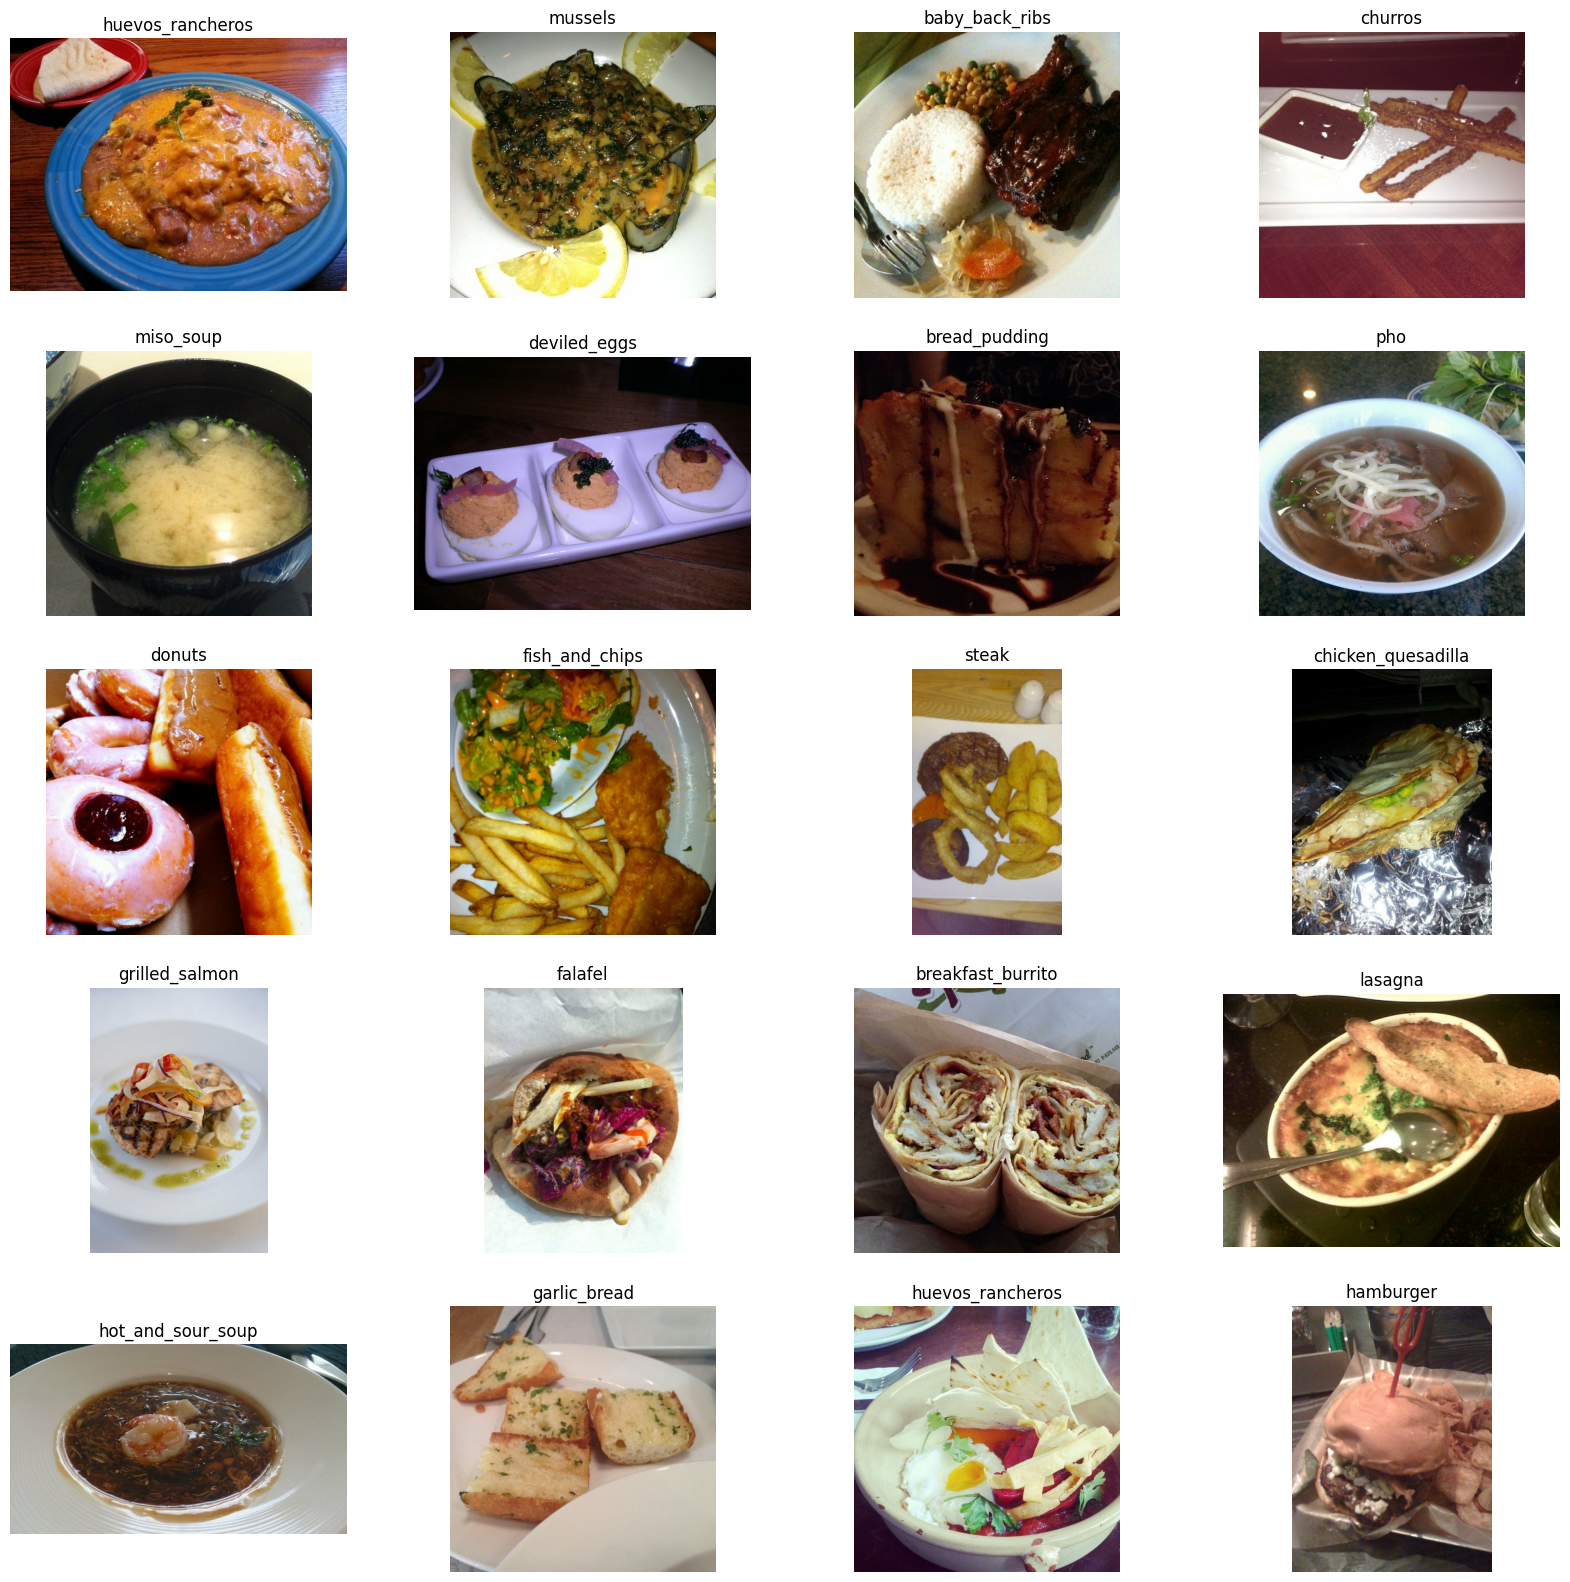

In [13]:
# Plot multiple image samples using matplotlib and set the title to target class name
# Function to visualize some random images from the dataset
import matplotlib.pyplot as plt
# Get factors.py
import os

if not os.path.exists("factors.py"):
    !wget https://raw.githubusercontent.com/ARGF0RCE/Food-Vision/main/factors.py
else:
    print("[INFO] 'factors.py' already exists, skipping download...")
from factors import *
def plot_random_images(dataset=train_data, figsize=(20, 20), no_of_samples=10):
    """Function to visualize a set of andom images sampled
    dataset.

    Args:
        dataset (<_OptionsDataset shapes: ((None, None, 3), ()), types: (tf.uint8, tf.int64)>, optional): Desired dataset. Defaults to train_data.
        figsize (tuple, optional): Desired figsize. Defaults to (5, 5).
        no_of_samples (int, optional): No. of samples to visualize. Defaults to 10.
    """
    image_tensors = []
    labels = []
    
    # global figure_size
    # if no_of_samples != 10:
    #     figure_size = (int(no_of_samples/2), int(no_of_samples/2))
    # else:
    #     figure_size = figsize
    plt.figure(figsize=figsize)
    samples = dataset.take(no_of_samples)
    for image, label in samples:
        # print(f"""
        # Image shape: {image.shape}
        # Image datatype: {image.dtype}
        # Target class from Food101 (tensor form): {label}
        # Class name (str form): {class_names[label.numpy()]}
        # """)
        image_tensors.append(image)
        labels.append(class_names[label.numpy()])
    for i, j in enumerate(image_tensors):
        plt.subplot(median(factorization(no_of_samples))[0], median(factorization(no_of_samples))[1], i + 1)
        plt.imshow(j)
        plt.title(labels[i])
        plt.axis(False);


plot_random_images(no_of_samples=20)

Now let's preprocess it and get it ready for use with a neural network

## Create Preprocessing functions for our data

Since we've downloaded the data from TensorFlow Datasets, there are a couple of preprocessing steps we have to take before it's ready to model.

More specifically our data is currently:

* In `unint8` datatype.
* Comprised of different sized tensors.
* Not scaled (the pixel values are between 0 & 255)

To take care of the preprocessing, we'll create a `preprocess_img()` function which:
* Resizes an input image tensor to a specified size using `tf.image.resize()`
* Converts an input image tensor's current datatype to tf.float32 using `tf.cast()`

> 🔑 **Note:** Pretrained EfficientNetBX models in `tf.keras.applications.efficientnet` have rescaling built-in. But for many other model architectures you'll want to rescale yoour data.

In [14]:
# Make a function for preprocessing images
def preprocess_img(image, label, img_shape=224):
    """
    Converts image datatype from `uint8` -> `float32` and reshape image to
    `[img_shape, img_shape, color_channels]`
    """
    image = tf.image.resize(image, [img_shape, img_shape]) # reshape to img_shape
    return tf.cast(image, tf.float32), label # return (float32_image, label) tuple

In [15]:
# Preprocess a single sample image and check the outputs
preprocessed_img = preprocess_img(image, label)[0]
print(f"Image before preprocessing:\n {image[:2]}...,\nShape: {image.shape},\nDatatype: {image.dtype}\n")
print(f"Image after preprocessing:\n {preprocessed_img[:2]}...,\nShape: {preprocessed_img.shape},\nDatatype: {preprocessed_img.dtype}")

Image before preprocessing:
 [[[ 64  27  11]
  [ 73  36  20]
  [ 83  46  28]
  ...
  [150 105  82]
  [138  93  72]
  [134  89  68]]

 [[ 69  32  16]
  [ 70  33  17]
  [ 72  35  17]
  ...
  [155 110  87]
  [141  96  75]
  [135  90  69]]]...,
Shape: (512, 512, 3),
Datatype: <dtype: 'uint8'>

Image after preprocessing:
 [[[ 69.69388    32.69388    16.693878 ]
  [ 78.44898    41.44898    22.520409 ]
  [ 78.35204    42.566326   16.137754 ]
  ...
  [211.34154   166.91301   141.69875  ]
  [172.38239   127.382385  104.382385 ]
  [138.04063    93.040634   72.040634 ]]

 [[ 63.693874   28.290815   10.499998 ]
  [ 60.137756   25.137754    3.2857132]
  [ 68.54082    33.484695    5.198978 ]
  ...
  [208.20901   164.19371   136.76518  ]
  [184.3518    140.48448   113.76002  ]
  [146.6731    104.673096   79.74452  ]]]...,
Shape: (224, 224, 3),
Datatype: <dtype: 'float32'>


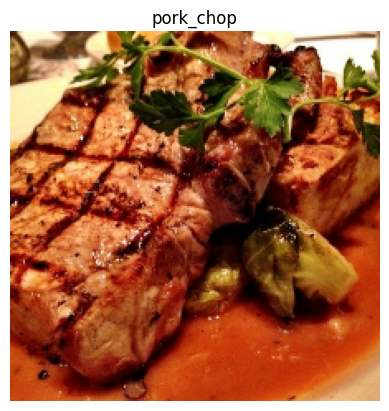

In [16]:
# We can still plot our preprocessed image as long as we 
# divide by 255 (for matplotlib capatibility)
plt.imshow(preprocessed_img/255.)
plt.title(class_names[label])
plt.axis(False);

## Batch & prepare datasets

